# Notebook init

In [1]:
%load_ext autoreload
%autoreload 2

from os import pardir, getcwd
from os.path import join, abspath, normpath, basename

rootDirectory = abspath(join(getcwd(), pardir))
dataDirectory = join(rootDirectory, 'data')
modelDirectory = join(rootDirectory, 'models')
currentSensorsh = ('https://raw.githubusercontent.com/fablabbcn/smartcitizen-kit-20/master/lib/Sensors/Sensors.h')

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML, display, clear_output, Markdown
from ipywidgets import interact
import ipywidgets as widgets

from src.data.recording_class import recordings
from src.data.test_utils import getSensorNames
currentSensorNames = getSensorNames(currentSensorsh, join(dataDirectory, 'interim'))

import matplotlib.pyplot as plot
plot.style.use('seaborn')
%matplotlib inline

# Initialise recordings
records = recordings()

print ('Notebook initialisation -> OK')

/Users/macoscar/anaconda2/envs/python3v/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


Loaded updated sensor names and dumped into /Users/macoscar/Documents/04_Projects/02_FabLab/01_SmartCitizen/01_Repositories/DataAnalysis/smartcitizen-iscape-data/data/interim/sensorNames.sav
Notebook initialisation -> OK


# Data Load

## Normal load

In [2]:
from src.data.test_utils import getTests
from src.data.api_utils import getKitID
import re

out_load = widgets.Output()

selectedTest = tuple()
def selectTests(x):
    global selectedTest
    selectedTest = list(x)
    selectedTestBases = list()
    selectedTestBases.append('')
    for test in selectedTest:
        selectedTestBases.append(basename(normpath(test)))
    name_drop_api.options = selectedTestBases
            
def loadButton(b):
    with out_load:
        clear_output()
        
        target_raster_csv = raster_text_csv.value + raster_drop_csv.value
        if na_drop_csv.value != 'None':
            na_drop_action = na_drop_csv.value
            na_dropage = True
        else:
            na_dropage = False
            na_drop_action = ''
        for testCSV in selectedTest:
            testName = basename(normpath(testCSV))
            records.add_recording_CSV(testName, testCSV, currentSensorNames, target_raster_csv, na_dropage, na_drop_action)
        
        
        if kitList_api.value != '':
            target_raster_api = raster_text_api.value + raster_drop_api.value
            devices = kitList_api.value.strip('').split(',')
            devicesCorrected = list()
            
            for device in devices: 
                device = re.sub(' ', '', device)
                devicesCorrected.append(device)
            
            if name_drop_api.value == '':
                testName = testName_api.value
                print (testName)

            else:
                testName = name_drop_api.value
            
            if testName != '':
                if na_drop_api.value != 'None':
                    na_drop_action = na_drop_api.value
                    na_dropage = True
                else:
                    na_dropage = False
                    na_drop_action = ''
                records.add_recording_API(testName, devicesCorrected, currentSensorNames, start_date_widget_api.value, end_date_widget_api.value, \
                                          target_raster_api, dataDirectory)
       
        unload_drop.options = records.readings.keys()
        
def clearButton(b):
    with out_load:
        clear_output()
        records.clear_recordings()
        unload_drop.options = records.readings.keys()
        
def clearAPI(b):
    with out_load:
        clear_output()
        kitList_api.value = ''
        testName_api.value = ''
        
def reload_list(b):
    with out_load:
        clear_output()
        global tests
        tests = getTests(dataDirectory)

def clearSelButton(b):
    with out_load:
        clear_output()
        records.del_recording(unload_drop.value)
        unload_drop.options = records.readings.keys()
        if len(records.readings.keys()) > 0:
            print ('Current recordings list:')
            for reading in records.readings.keys():
                print ('\t',reading)
        else:
            print ('Current recordings list is empty')
        
## API
banner_api = widgets.HTML('<h3>Import API Tests</h3>')
kitList_api = widgets.Text(description = 'Kit List')
testName_api = widgets.Text(description = 'Test Name')

name_drop_api = widgets.Dropdown(options = selectedTest,
                                  description = 'Merge with CSV',
                                  layout = widgets.Layout(width='300px'))

raster_text_api = widgets.Text(description = 'Target Raster',
                              value = '1',
                              layout = widgets.Layout(width='300px'))

raster_drop_api = widgets.Dropdown(options = ['H', 'Min', 'S'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

na_drop_api = widgets.Dropdown(options = ['None', 'fill', 'drop'],
                                  value = 'fill',
                                  description = 'Process na',
                                  layout = widgets.Layout(width='200px'))

clearAPIB = widgets.Button(description = 'Clear')
clearAPIB.on_click(clearAPI)

start_date_widget_api = widgets.DatePicker(description='Start Date')
end_date_widget_api = widgets.DatePicker(description='End Date')
dateBox_api = widgets.VBox([start_date_widget_api, end_date_widget_api, clearAPIB])

raster_box_api = widgets.HBox([raster_text_api, raster_drop_api, na_drop_api])
namebox_api = widgets.HBox([testName_api, name_drop_api])
Hbox_api = widgets.VBox([kitList_api, namebox_api])
apiBox = widgets.VBox([banner_api, Hbox_api, raster_box_api, dateBox_api])
        
## CSV
reload_list_button = widgets.Button(description='Reload List')
reload_list_button.on_click(reload_list)

display(widgets.HTML('<h2>Test load</h2>'))
display(widgets.HBox([widgets.HTML('<h3>Import CSV Tests</h3>')]),#, reload_list_button]),
       layout = widgets.Layout(justify='space-between'))

tests = getTests(dataDirectory)

interact(selectTests,
         x = widgets.SelectMultiple(options=tests, 
                           selected_labels = selectedTest, 
                           layout=widgets.Layout(width='600px')))

raster_text_csv = widgets.Text(description = 'Target Raster',
                              value = '1',
                              layout = widgets.Layout(width='300px'))

raster_drop_csv = widgets.Dropdown(options = ['H', 'Min', 'S', 'ms'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

na_drop_csv = widgets.Dropdown(options = ['None', 'fill', 'drop'],
                                  value = 'fill',
                                  description = 'Process na',
                                  layout = widgets.Layout(width='200px'))

raster_box_csv = widgets.HBox([raster_text_csv, raster_drop_csv, na_drop_csv])

# buttonBox_csv = widgets.HBox([loadB_csv, resetB_csv])
csvBox = widgets.VBox([raster_box_csv])#, buttonBox_csv])

loadB = widgets.Button(description='Load')
loadB.on_click(loadButton)

resetB = widgets.Button(description='Clear All')
resetB.on_click(clearButton)

unload_drop = widgets.Dropdown(options = records.readings.keys(),
                                  layout = widgets.Layout(width='200px'))

resetOneB = widgets.Button(description='Clear Selected')
resetOneB.on_click(clearSelButton)

buttonBox = widgets.HBox([loadB, resetB, unload_drop, resetOneB])
# Display everything
display(csvBox)
display(apiBox)
display(widgets.HTML('<hr>'))
display(buttonBox)
display(out_load)

HTML(value='<h2>Test load</h2>')

interactive(children=(SelectMultiple(description='x', layout=Layout(width='600px'), options={'2017-06_INT_FIRM…

HTML(value='<hr>')

Output()

## Manual load

In [3]:
from os.path import join
import os
import pandas as pd

folder = '/Users/macoscar/Documents/04_Projects/02_FabLab/01_SmartCitizen/04_Development/iScape/02_Deployments/KITS/05_6_pack/'

name_reading = 'DISPERSION'
readings = dict()
readings[name_reading] = dict()
readings[name_reading]['devices'] = dict()


for root, dirs, files in os.walk(folder):
    print 'Loading files in', folder
    for _file in files:
        if _file.endswith(".CSV") or _file.endswith(".csv"):
            print _file
            name = _file[:_file.find('.')]
            dataframe = pd.read_csv(join(folder, _file), skiprows=range(1,4)).set_index('Time')
            dataframe.index = pd.to_datetime(dataframe.index).tz_localize('UTC').tz_convert('Europe/Madrid')
            dataframe.index.rename('Time', inplace = True)
            dataframe.index.strftime('%Y-%m-%dT%H%M%SZ')
            dataframe.sort_index(inplace=True)
            
            # Remove duplicates from index
            dataframe = dataframe[~dataframe.index.duplicated(keep='first')]
            
            dataframe = dataframe.apply(pd.to_numeric,errors='coerce')     
            dataframe.fillna(0)
            
            readings[name_reading]['devices'][name] = dict()
            readings[name_reading]['devices'][name]['data'] = dataframe

Loading files in /Users/macoscar/Documents/04_Projects/02_FabLab/01_SmartCitizen/04_Development/iScape/02_Deployments/KITS/05_6_pack/
5469.csv
5470.csv
5471.csv
5472.csv
5473.csv
5474.csv


# Load metrics

## Calculate them

In [9]:
from os import getcwd, walk
from os.path import join
import pandas as pd

devices = dict()
for root, dirs, files in walk(folder):
    for _file in files:
        if _file.endswith(".csv"):
            ocur = _file.find('.')
            readings_name = _file[:ocur]
            readings[name_reading]['devices'][readings_name] = dict()
            
            # Create pandas dataframe
            df = pd.read_csv(join(folder,_file), verbose=False).set_index('Unnamed: 0')

            df.index.rename('Time', inplace = True)
            df.index = pd.to_datetime(df.index).tz_localize('UTC')
        
            df.sort_index(inplace=True)
            df = df.apply(pd.to_numeric,errors='coerce')            
            df.fillna(0)
            max_date = df.index[-1]            
            readings[name_reading]['devices'][readings_name]['data'] = df
            
list_channels = list()

# Get list of devices
list_devices = list(readings[dispersion_test]['devices'].keys())
# Init list of common channels
list_channels = readings[dispersion_test]['devices'][list_devices[0]]['data'].columns

# Extract list of common channels
for device in readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(readings[dispersion_test]['devices'][device]['data'].columns))

print(list_channels)         
            
dispersion_df = pd.DataFrame()

for channel in list_channels:
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    for device in list_devices:
        
        dispersion_df[channel + '-' + device] = readings[dispersion_test]['devices'][device]['data'].loc[:,channel].astype('float64')
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    dispersion_global = dispersion_df[channel + '_STD'].mean()
    print channel, dispersion_global

KeyError: 'Unnamed: 0'

## Load from history

In [3]:
## Channel, dev, sigma
dispersion_history = (['NOISE_A', 2.33323416585, 5],
                      ['TEMP', 0.402864267636, 5],
                      ['HUM', 1.49624685732, 5],
                      ['PM_1', 1.35653211631, 2],
                      ['PM_10', 2.3327409954, 2],
                      ['PM_25', 1.94100236525, 2],
                      ['PRESS', 0.0490177780217, 3])

# Extract faulty devices

Min - Max Date
2019-02-27 13:09:00+01:00 2019-02-28 16:20:00+01:00
['NOISE_A', 'TEMP', 'PM_10', 'HUM', 'PRESS', 'PM_25', 'PM_1']


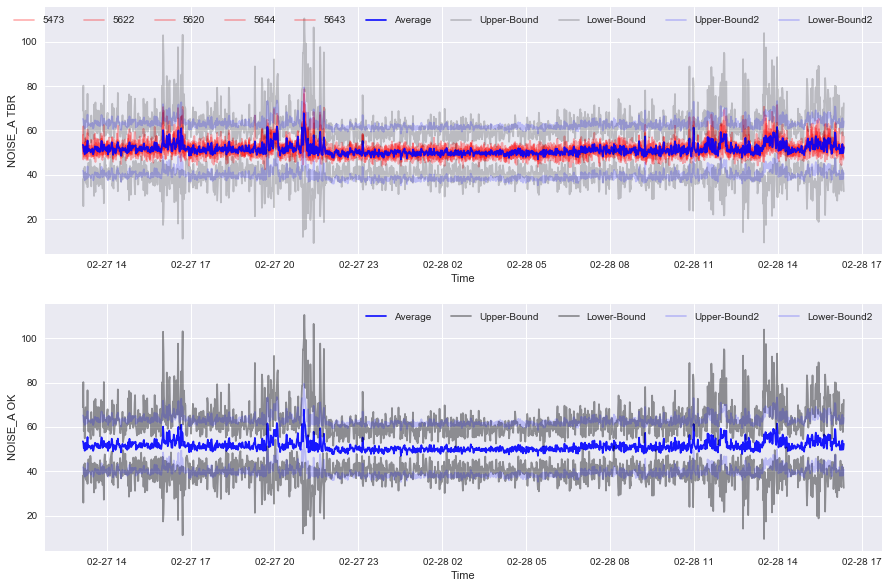

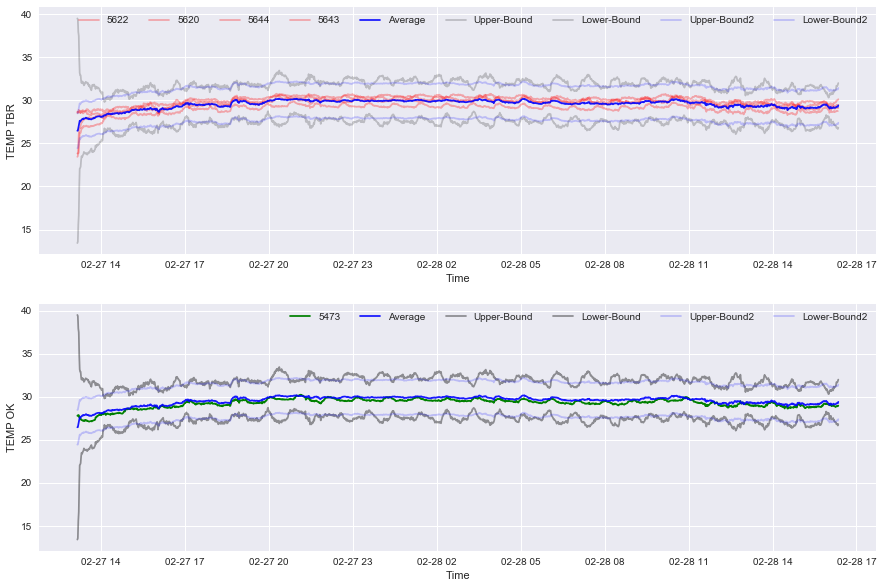

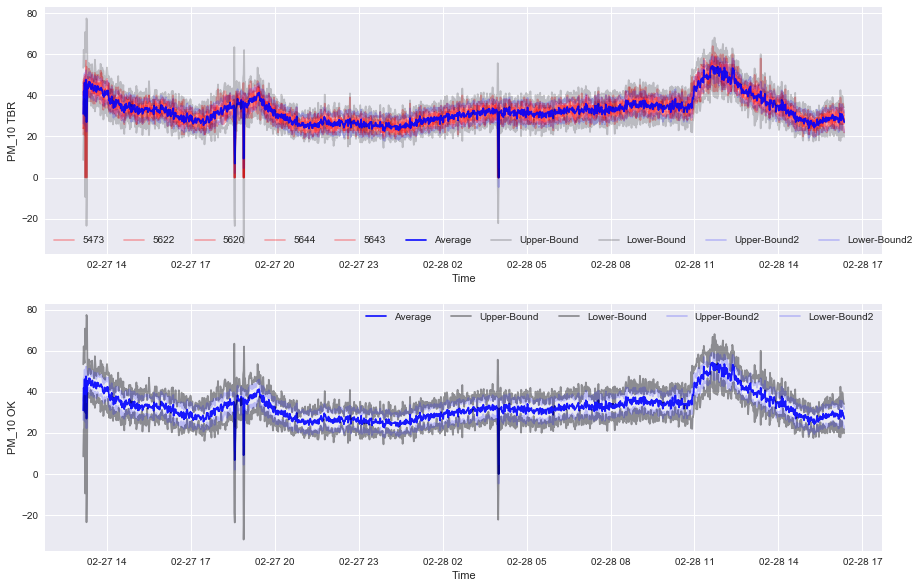

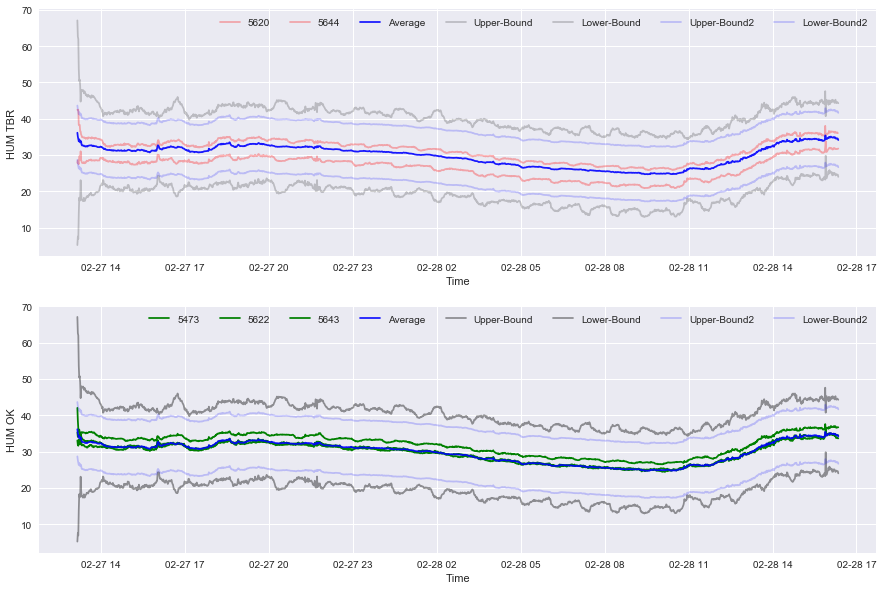

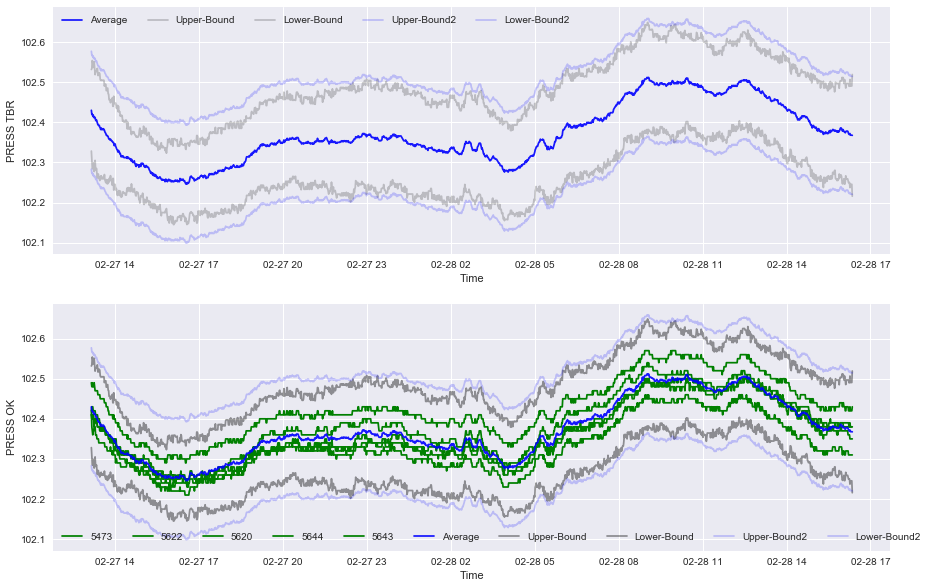

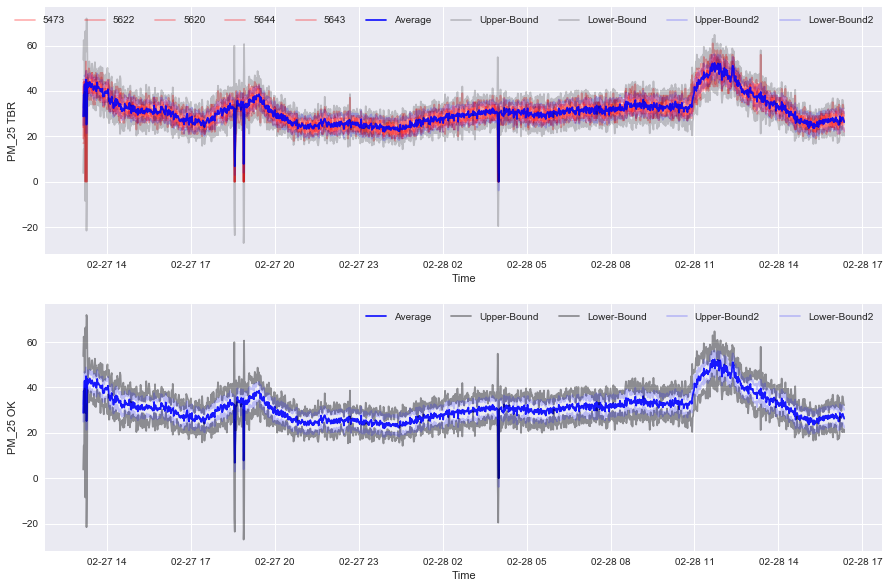

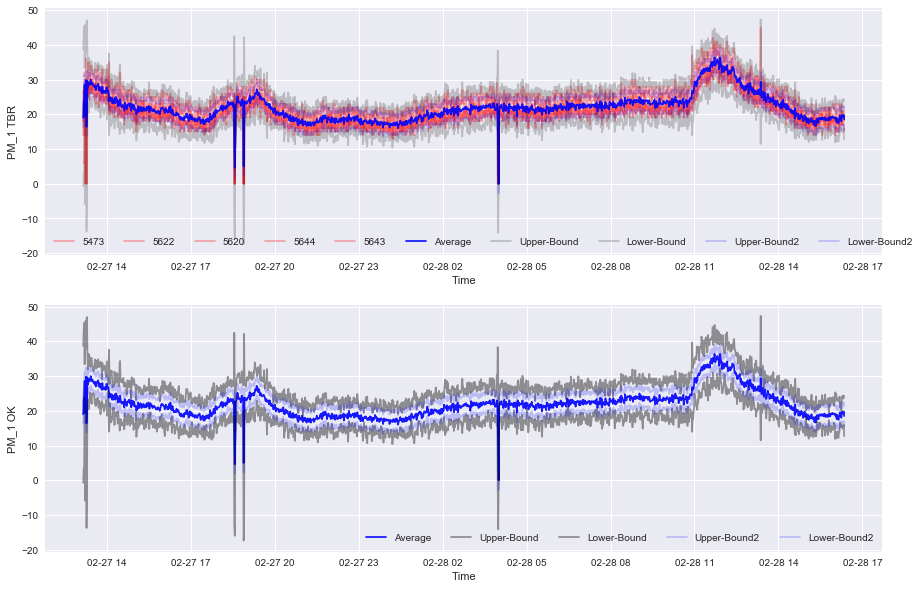

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

dispersion_test = 'COLUMBIA'

list_channels = list()

# Get list of devices
list_devices = list(records.readings[dispersion_test]['devices'].keys())

# Init list of common channels
list_channels = records.readings[dispersion_test]['devices'][list_devices[0]]['data'].columns
min_date = pd.to_datetime('2000-01-01 00:00:00')
max_date = pd.to_datetime('2100-01-01 00:00:00')

min_date = min_date.tz_localize('UTC').tz_convert('Europe/Madrid')
max_date = max_date.tz_localize('UTC').tz_convert('Europe/Madrid')

# Extract list of common channels
for device in records.readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(records.readings[dispersion_test]['devices'][device]['data'].columns))
    min_date = max(records.readings[dispersion_test]['devices'][device]['data'].index[0], min_date)
    max_date = min(records.readings[dispersion_test]['devices'][device]['data'].index[-1], max_date)

print ('Min - Max Date')
print (min_date, max_date)
if 'BATT' in list_channels: list_channels.remove('BATT')
if 'LIGHT' in list_channels: list_channels.remove('LIGHT')

print(list_channels)

# Trim dataset to min and max dates (normally these tests are carried out with _minutes_ of differences)
for device in list_devices:
    dataframe_cut = records.readings[dispersion_test]['devices'][device]['data']
    dataframe_cut = dataframe_cut[dataframe_cut.index > min_date]
    dataframe_cut = dataframe_cut[dataframe_cut.index < max_date]
    
dispersion_df = pd.DataFrame()

for channel in list_channels:
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    for device in list_devices:
        # Important to resample and bfill for unmatching measures
        dispersion_df[channel + '-' + device] = records.readings[dispersion_test]['devices'][device]['data'][channel].resample('1Min').bfill()
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_AVG'] = dispersion_df.loc[:,list_columns].mean(skipna=True, axis = 1)
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    
    dispersion_global = 0
    limit_confidence_sigma = 0
    for item in dispersion_history:
        if channel == item[0]:
            dispersion_global = item[1]
            limit_confidence_sigma = item[2]
    
    dispersion_df[channel + '_MAX'] = dispersion_df.loc[:,list_columns].max(skipna=True, axis = 1)
    dispersion_df[channel + '_MIN'] = dispersion_df.loc[:,list_columns].min(skipna=True, axis = 1)
    
    upper_bound = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_df[channel + '_STD']
    lower_bound = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_df[channel + '_STD']
    
    upper_bound2 = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_global
    lower_bound2 = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_global
        
    for device in list_devices:
        if any(dispersion_df[channel + '-' + device] > upper_bound2) or any(dispersion_df[channel + '-' + device] < lower_bound2):
            alpha = 0.3
            color = 'r'
            ax1.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

        else:
            alpha = 1
            color = 'g'
            ax2.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

    ax1.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax1.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.2)
    
    ax1.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound2', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound2', alpha = 0.2)
    ax1.legend(loc='best', ncol = 10)
    ax1.grid(True)
    ax1.set_ylabel(channel + ' TBR')
    ax1.set_xlabel('Time')
    
    ax2.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax2.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.4)
    ax2.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.4)

    ax2.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound2', alpha = 0.2)
    ax2.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound2', alpha = 0.2)
    ax2.legend(loc='best', ncol = 10)
    ax2.grid(True)
    ax2.set_ylabel(channel + ' OK')
    ax2.set_xlabel('Time')
    
plot.show()